### Library Set-up

In [1]:
# Scientic libraries
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import logging
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from credit_risk_model import config

# Helper libraries 
from tqdm.notebook import tqdm,trange
import warnings 
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina' # sets the figure format to 'retina' for high-resolution displays.

# Pandas options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # To display all interaction 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15) # When you print dataframes, 15 rows will be printed

# This code is auto reloading the kernel when any .py file is changed and saved.
%load_ext autoreload
%autoreload 2

# Table styles
table_styles = {
    'cerulean_palette': [
        dict(selector="th", props=[("color", "#FFFFFF"), ("background", "#004D80")]),
        dict(selector="td", props=[("color", "#333333")]),
        dict(selector="table", props=[("font-family", 'Arial'), ("border-collapse", "collapse")]),
        dict(selector='tr:nth-child(even)', props=[('background', '#D3EEFF')]),
        dict(selector='tr:nth-child(odd)', props=[('background', '#FFFFFF')]),
        dict(selector="th", props=[("border", "1px solid #0070BA")]),
        dict(selector="td", props=[("border", "1px solid #0070BA")]),
        dict(selector="tr:hover", props=[("background", "#80D0FF")]),
        dict(selector="tr", props=[("transition", "background 0.5s ease")]),
        dict(selector="th:hover", props=[("font-size", "1.07rem")]),
        dict(selector="th", props=[("transition", "font-size 0.5s ease-in-out")]),
        dict(selector="td:hover", props=[('font-size', '1.07rem'),('font-weight', 'bold')]),
        dict(selector="td", props=[("transition", "font-size 0.5s ease-in-out")])
    ]
}

# Seed value for numpy.random => makes notebooks stable across runs
np.random.seed(config.RANDOM_SEED)

### Data Ingestion

In [2]:
import credit_risk_model.data_processor as dp
df = dp.load_data_and_sanitize(config.FILE_NAME)

In [3]:
df['earliest_cr_line']=pd.to_datetime(df['earliest_cr_line'],format='%b-%Y')

In [4]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  float64       
 1   term                  396030 non-null  object        
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  object        
 5   sub_grade             396030 non-null  object        
 6   emp_title             373103 non-null  object        
 7   emp_length            377729 non-null  object        
 8   home_ownership        396030 non-null  object        
 9   annual_inc            396030 non-null  float64       
 10  verification_status   396030 non-null  object        
 11  issue_d               396030 non-null  datetime64[ns]
 12  loan_status           396030 non-null  object        
 13 

### EDA

In [6]:
# Instead of doing all the EDA manually will make use of Pandas reporting
from ydata_profiling import ProfileReport
# profile = ProfileReport(df,title='Pandas profiling of the dataset',explorative=True)
# profile.to_notebook_iframe()

#### Important points on the data after EDA using ydata profiling:
* Loan amount is little right skewed.
* Term has 2 categories 36 months and 60 months.
* The data has no duplicates.
* Interest rate is slightly skewed and has no missing values.
* Intsallment amount is also highly right skewed but we would not want to use it in analysis, as installment will be decided after the company has decided to give the loan, but here the objective is whether to give loan or not.
* The grade of the loans is categorical with B being the most common and G being the least common.
* There are a lot of categories in the employee_title column with missing values, won't be much useful for our analysis.
* The employee_length has 11 distinct categories with most common category being more than 10 years.
* Home ownership has 6 distinct categories, out of which the last 2 categories occur very less number of times.
* Annual income is highly skewed with skew value of around 41. Need to transform this column if applying logistic regression.
* Issue d is the issue date which will be after the loan has been approved, but here our objective is to check if the loan should be approved or not, so we can remove the column to avoid data leakage.
* There are almost 48k distinct values in title column so that will not be useful for us.
* Open_acc and Pub_rec are also highly right skewed.
* Revol_bal is also right skewed.
* Revol util is very slightly left skewed and close to normal so will not transform this.
* Total account is slightly right skewed.
* Mortgage accounts also is right skewed should be transformed.
* pub_rec_bankruptcies is also right skewed and should be transformed.
* The last 6 digits of address column is the zipcode which can be a useful feature.

### Test Data separation

In [7]:
x = df.drop(columns=[config.TARGET])
y = df[config.TARGET]
from sklearn.model_selection import train_test_split

In [8]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [9]:
# Validating if we have created a proper train and test split which is representative of the entire dataset
# Create a profile report for the train dataset
train_profile = ProfileReport(x_train, title="Train Dataset Profile", explorative=True)

# Creating a profile report for test dataset
test_profile = ProfileReport(x_test,title='Test Dataset Profile', explorative=True)

In [10]:
# We can compare the stats of train and test dataset using the below code.
# comparision_report = train_profile.compare(test_profile)
# comparision_report.to_notebook_iframe()

### Outlier removal

In [11]:
# Removing outliers in the training dataset and storing it in a different training set x_train_NO

num = config.NUM_FEATURES + config.NUM_SKEWED_FEATURES

q1 = df[num].quantile(0.25)
q3 = df[num].quantile(0.75)
iqr = q3-q1


In [12]:
x_train_NO = x_train[~((x_train[num]<q1-(1.5*iqr)) | (x_train[num]>q3+(1.5*iqr))).any(axis=1)]

In [13]:
y_train_NO = y_train.loc[x_train_NO.index]

### Feature engineering

* Let's remove the columns installment, issue_d and int_rate, because these things are given after the loan approval, but in our analysis we have to decide whether to give a loan or not so removing these to avoid data leakage.
* Removing emp_title column as there are so many distinct values in it.
* Absolute dates doesn't add any positive effect on the model so will remove it, alternatively we can create any relative date columns like difference between start date and end date etc.

According to Feature engineering principles there are different types of data:
1) Categorical ordinal data - Data which is categorical and has meaningful order (like small, medium, large)
2) Categorical nominal data - Data which is categorical but doesn't have any meaningful order (like brands Nike, adidas, reebok etc)
3) Numerical Discrete data - Data which is numerical and discrete which is 10,20,30 etc.
4) Numerical continuos data - Data which is numerical and continuos.

In [14]:
from sklearn import set_config
set_config(transform_output = "pandas")
from credit_risk_model.config import *

In [15]:
#Importing all the pipelines created in FE_pipeline.py file
from credit_risk_model.FE_pipeline import num_pipeline,num_skewed_pipeline,nominal_cat_pipeline,ordinal_cat_pipeline,selected_FE_with_FS,selected_FE

loan_status


In [16]:
selected_FE_with_FS.fit(x_train,y_train)

Pipeline(steps=[('feature_engineering_pipeline',
                 FeatureUnion(transformer_list=[('combined_numerical_pipeline',
                                                 Pipeline(steps=[('all_numerical',
                                                                  FeatureUnion(transformer_list=[('num_skewed_pipeline',
                                                                                                  Pipeline(steps=[('select_skewed_features',
                                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000291A677B6A0>)),
                                                                                                                  ('skewed_imputer',
                                                                                                                   SimpleImputer(strategy='med...
                                                                                              'F1',
                                                                                              'F2',
                                                                                              'F3',
                                                                                              'F4',
                                                                                              'F5', ...],
                                                                                             ['< '
                                                                                              '1 '
                                                                                              'year',
                                                                                              '1 '
                                                                                              'year',
                                                                                              '2 '
                                                                                              'years',
                                                                                              '3 '
                                                                                              'years',
                                                                                              '4 '
                                                                                              'years',
                                                                                              '5 '
                                                                                              'years',
                                                                                              '6 '
                                                                                              'years',
                                                                                              '7 '
                                                                                              'years',
                                                                                              '8 '
                                                                                              'years',
                                                                                              '9 '
                                                                                              'years',
                                                                                              '10+ '
                                                                                              'years'],
                                                                                             ['Not '
                                                                                              'Verified',
                           

In [17]:
config.POST_FE_FEATURES = selected_FE_with_FS.transform(x_test).columns

### Model Selection and Training
#### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from credit_risk_model.FE_pipeline import target_pipeline

pipe1_LR = Pipeline(steps=[
    ('feature_engineering_pipeline',selected_FE_with_FS),
    ('logreg',LogisticRegression())
])
# Please note that the params here are the best hyper parameter tuned parameters, after tuning just kept the best ones here
# For less amount of execution time of the notebook
params = {'logreg__C': [0.01],
 'logreg__class_weight': ['balanced'],
 'logreg__max_iter': [1000],
 'logreg__penalty': ['l2']}
grid1_LR = GridSearchCV(pipe1_LR,param_grid=params,cv=3,scoring='f1',n_jobs=config.N_JOBS,verbose=1)
y_train_transformed = target_pipeline.transform(y_train)
y_test_transformed = target_pipeline.transform(y_test)

In [19]:
grid1_LR.fit(x_train,y_train_transformed)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                        Pipeline(steps=[('feature_engineering_pipeline',
                                                         FeatureUnion(transformer_list=[('combined_numerical_pipeline',
                                                                                         Pipeline(steps=[('all_numerical',
                                                                                                          FeatureUnion(transformer_list=[('num_skewed_pipeline',
                                                                                                                                          Pipeline(steps=[('select_skewed_features',
                                                                                                                                                           FunctionTransformer(func=<function <...
                                                                                                                                      'Source '
                                                                                                                                      'Verified']],
                                                                                                                         handle_unknown='use_encoded_value',
                                                                                                                         unknown_value=-1))]))])),
                                                        ('feature_selection',
                                                         SelectKBest(k=30,
                                                                     score_func=<function chi2 at 0x00000291A7C1D3A0>))])),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01],
                         'logreg__class_weight': ['balanced'],
                         'logreg__max_iter': [1000],
                         'logreg__penalty': ['l2']},
             scoring='f1', verbose=1)

In [20]:
grid1_LR.best_score_
LR_best_model = grid1_LR.best_estimator_

np.float64(0.6143256596953729)

In [21]:
from sklearn.metrics import classification_report
y_pred1 = LR_best_model.predict(x_test)
print(classification_report(y_test_transformed,y_pred1))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     95507
           1       0.51      0.79      0.62     23302

    accuracy                           0.81    118809
   macro avg       0.72      0.80      0.74    118809
weighted avg       0.86      0.81      0.82    118809



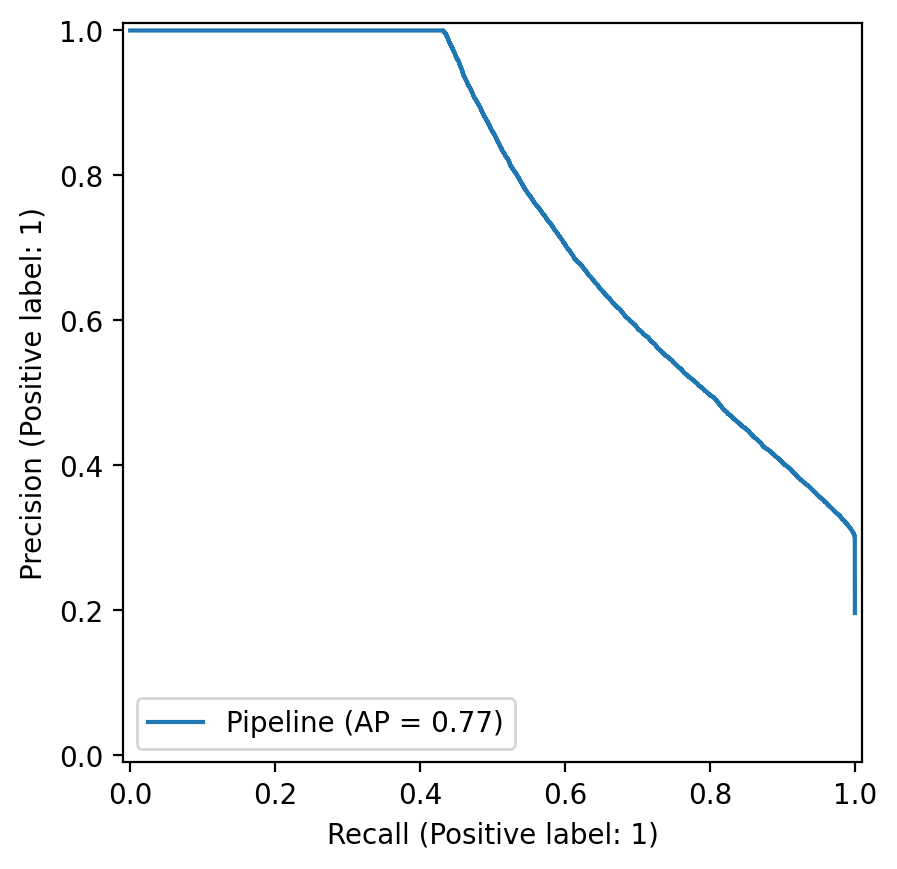

In [22]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(LR_best_model,x_test,y_test_transformed)

One important thing which should be done is choosing the threshold for classifying to class 1 or 0.
The classification report above was given by assuming the default threshold of 0.5.
Now let's find out the correct threshold.

#### Threshold Adjustment for Logistic Regression

Classification report: Training set
              precision    recall  f1-score   support

           0       0.91      0.93      0.92    222850
           1       0.69      0.61      0.65     54371

    accuracy                           0.87    277221
   macro avg       0.80      0.77      0.78    277221
weighted avg       0.87      0.87      0.87    277221

Classification report: Test set
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     95507
           1       0.69      0.61      0.65     23302

    accuracy                           0.87    118809
   macro avg       0.80      0.77      0.78    118809
weighted avg       0.87      0.87      0.87    118809

Best threshold = 0.65 with f1 score = 0.65


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                                      Pipeline(steps=[('feature_engineering_pipeline',
                                                                       FeatureUnion(transformer_list=[('combined_numerical_pipeline',
                                                                                                       Pipeline(steps=[('all_numerical',
                                                                                                                        FeatureUnion(transformer_list=[('num_skewed_pipeline',
                                                                                                                                                        Pipeline(steps=[('select_skewed_features',
                                                                                                                                                                         FunctionTransformer(f...
                                                                                                                                                    'years',
                                                                                                                                                    '9 '
                                                                                                                                                    'years',
                                                                                                                                                    '10+ '
                                                                                                                                                    'years'],
                                                                                                                                                   ['Not '
                                                                                                                                                    'Verified',
                                                                                                                                                    'Verified',
                                                                                                                                                    'Source '
                                                                                                                                                    'Verified']],
                                                                                                                                       handle_unknown='use_encoded_value',
                                                                                                                                       unknown_value=-1))]))])),
                                                                      ('feature_selection',
                                                                       SelectKBest(k=30,
                                                                                   score_func=<function chi2 at 0x00000291A7C1D3A0>))])),
                                                     ('logreg',
                                                      LogisticRegression(C=0.01,
                                                                         class_weight='balanced',
                                                                         max_iter=1000))]),
                           n_jobs=-1, scoring='f1', store_cv_results=True)

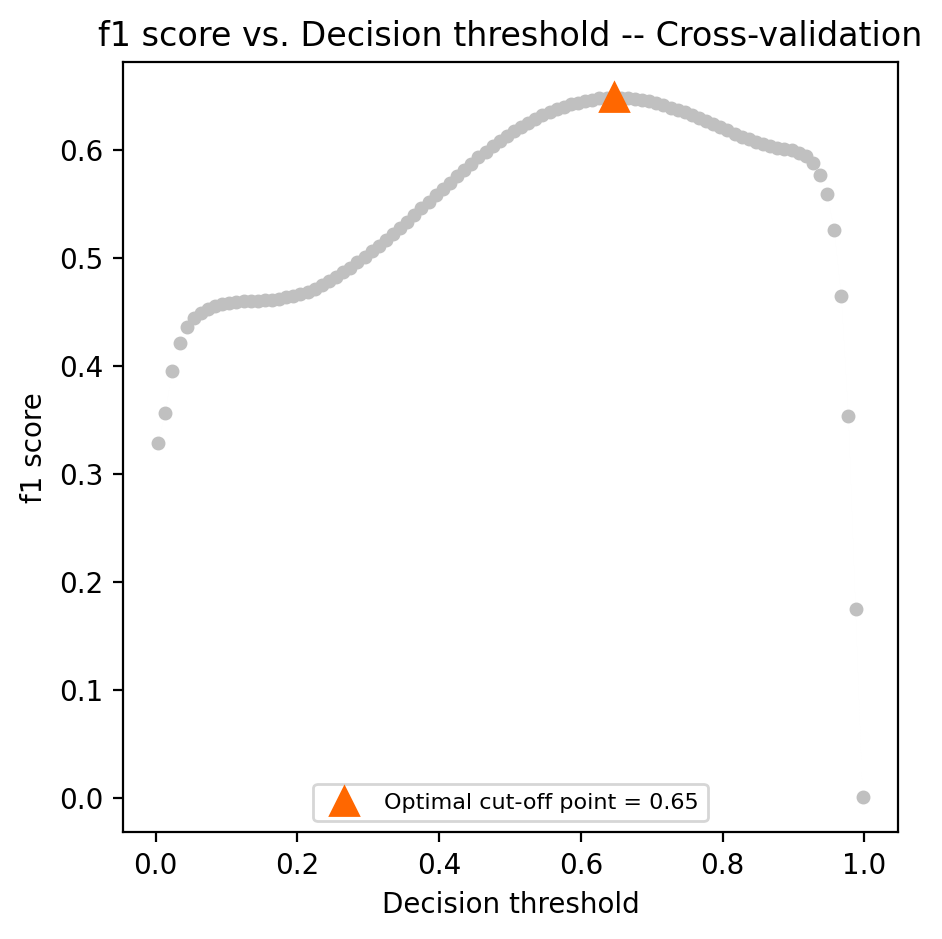

In [23]:
from credit_risk_model.tune_threshold import find_the_best_decision_threshold
find_the_best_decision_threshold(LR_best_model,x_train,y_train,x_test,y_test,scoring='f1')

### Feature importance of Logistic Regression

In [25]:
 
importance = LR_best_model.named_steps['logreg'].coef_[0]
pd.DataFrame({'feature':config.POST_FE_FEATURES,'importance':importance}).sort_values(by='importance',ascending=False)

,feature,importance
25,zipcode_93700,3.891274
22,zipcode_11650,3.886433
24,zipcode_86630,3.873952
3,revol_util,0.645250
26,term,0.369915
...,...,...
13,title_consolidation,-0.300003
16,title_infrequent_sklearn,-0.333492
20,zipcode_00813,-3.895977
21,zipcode_05113,-3.896370


#### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
pipe2_RF = Pipeline(steps=[
    ('feature_engineering_pipeline',selected_FE_with_FS),
    ('rfc',RandomForestClassifier())
])
# Please note that the params dictionary are the already tuned best parameters
params = {
 'rfc__class_weight': ['balanced'],
 'rfc__max_depth': [8],
 'rfc__max_samples': [0.4],
 'rfc__n_estimators': [150]
}

grid2_RF = GridSearchCV(pipe2_RF,param_grid=params,cv=3,scoring='f1',verbose=1,n_jobs=config.N_JOBS)
grid2_RF.fit(x_train,y_train_transformed)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                        Pipeline(steps=[('feature_engineering_pipeline',
                                                         FeatureUnion(transformer_list=[('combined_numerical_pipeline',
                                                                                         Pipeline(steps=[('all_numerical',
                                                                                                          FeatureUnion(transformer_list=[('num_skewed_pipeline',
                                                                                                                                          Pipeline(steps=[('select_skewed_features',
                                                                                                                                                           FunctionTransformer(func=<function <...
                                                                                                                                      'Source '
                                                                                                                                      'Verified']],
                                                                                                                         handle_unknown='use_encoded_value',
                                                                                                                         unknown_value=-1))]))])),
                                                        ('feature_selection',
                                                         SelectKBest(k=30,
                                                                     score_func=<function chi2 at 0x00000291A7C1D3A0>))])),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rfc__class_weight': ['balanced'],
                         'rfc__max_depth': [8], 'rfc__max_samples': [0.4],
                         'rfc__n_estimators': [150]},
             scoring='f1', verbose=1)

In [25]:
grid2_RF.best_score_
RF_best_model = grid2_RF.best_estimator_

np.float64(0.5922813192860135)

In [26]:
y_pred2 = RF_best_model.predict(x_test)
print(classification_report(y_test_transformed,y_pred2))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     95507
           1       0.45      0.84      0.59     23302

    accuracy                           0.77    118809
   macro avg       0.70      0.80      0.71    118809
weighted avg       0.85      0.77      0.79    118809



#### Threshold adjustment for Random Forest

Classification report: Training set
              precision    recall  f1-score   support

           0       0.90      0.94      0.92    222850
           1       0.72      0.59      0.65     54371

    accuracy                           0.87    277221
   macro avg       0.81      0.77      0.79    277221
weighted avg       0.87      0.87      0.87    277221

Classification report: Test set
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     95507
           1       0.72      0.59      0.65     23302

    accuracy                           0.87    118809
   macro avg       0.81      0.77      0.79    118809
weighted avg       0.87      0.87      0.87    118809

Best threshold = 0.64 with f1 score = 0.65


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                                      Pipeline(steps=[('feature_engineering_pipeline',
                                                                       FeatureUnion(transformer_list=[('combined_numerical_pipeline',
                                                                                                       Pipeline(steps=[('all_numerical',
                                                                                                                        FeatureUnion(transformer_list=[('num_skewed_pipeline',
                                                                                                                                                        Pipeline(steps=[('select_skewed_features',
                                                                                                                                                                         FunctionTransformer(f...
                                                                                                                                                    'years'],
                                                                                                                                                   ['Not '
                                                                                                                                                    'Verified',
                                                                                                                                                    'Verified',
                                                                                                                                                    'Source '
                                                                                                                                                    'Verified']],
                                                                                                                                       handle_unknown='use_encoded_value',
                                                                                                                                       unknown_value=-1))]))])),
                                                                      ('feature_selection',
                                                                       SelectKBest(k=30,
                                                                                   score_func=<function chi2 at 0x00000291A7C1D3A0>))])),
                                                     ('rfc',
                                                      RandomForestClassifier(class_weight='balanced',
                                                                             max_depth=8,
                                                                             max_samples=0.4,
                                                                             n_estimators=150))]),
                           n_jobs=-1, scoring='f1', store_cv_results=True)

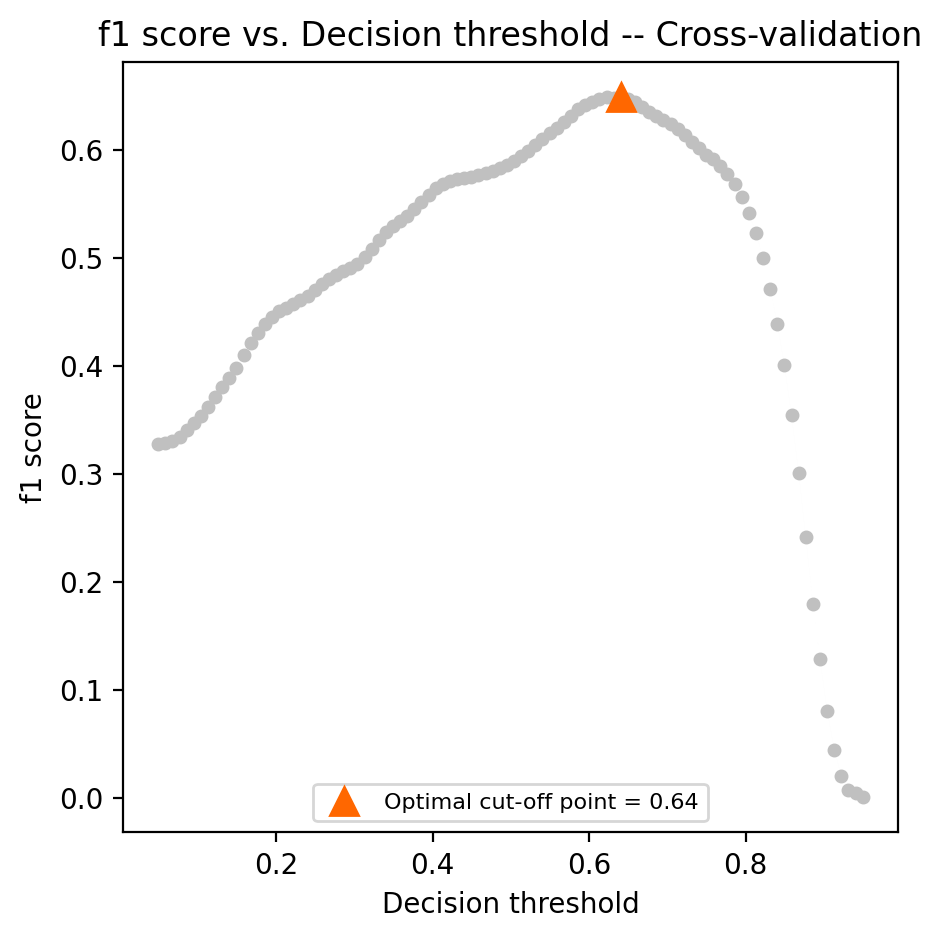

In [27]:
find_the_best_decision_threshold(RF_best_model,x_train,y_train,x_test,y_test,scoring='f1')

### Feature importance of Random Forests

In [28]:
pd.DataFrame({'feature':config.POST_FE_FEATURES,'importance':RF_best_model.named_steps['rfc'].feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
23,zipcode_29597,0.140123
21,zipcode_05113,0.128784
20,zipcode_00813,0.127094
22,zipcode_11650,0.127069
25,zipcode_93700,0.124438
...,...,...
11,purpose_other,0.000044
6,purpose_car,0.000044
9,purpose_home_improvement,0.000040
15,title_other,0.000038


### XGBoost

In [29]:
from xgboost import XGBClassifier

pipe3_XGB = Pipeline(steps=[
    ('feature_engineering_pipeline',selected_FE_with_FS),
    ('xgb',XGBClassifier())
])

params = {'xgb__learning_rate': [0.2],
 'xgb__max_depth': [5],
 'xgb__min_samples_leaf': [12],
 'xgb__n_estimators': [250]}

grid3_XGB = GridSearchCV(pipe3_XGB,param_grid=params,cv=3,scoring='f1',n_jobs=config.N_JOBS,verbose=1)
grid3_XGB.fit(x_train,y_train_transformed)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                        Pipeline(steps=[('feature_engineering_pipeline',
                                                         FeatureUnion(transformer_list=[('combined_numerical_pipeline',
                                                                                         Pipeline(steps=[('all_numerical',
                                                                                                          FeatureUnion(transformer_list=[('num_skewed_pipeline',
                                                                                                                                          Pipeline(steps=[('select_skewed_features',
                                                                                                                                                           FunctionTransformer(func=<function <...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.2], 'xgb__max_depth': [5],
                         'xgb__min_samples_leaf': [12],
                         'xgb__n_estimators': [250]},
             scoring='f1', verbose=1)

In [30]:
grid3_XGB.best_score_
XGB_best_model = grid3_XGB.best_estimator_

np.float64(0.6205288477989318)

In [31]:
y_pred3 = XGB_best_model.predict(x_test)
print(classification_report(y_test_transformed,y_pred3))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     95507
           1       0.94      0.47      0.62     23302

    accuracy                           0.89    118809
   macro avg       0.91      0.73      0.78    118809
weighted avg       0.89      0.89      0.87    118809



Classification report: Training set
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    222850
           1       0.75      0.61      0.67     54371

    accuracy                           0.88    277221
   macro avg       0.83      0.78      0.80    277221
weighted avg       0.88      0.88      0.88    277221

Classification report: Test set
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     95507
           1       0.72      0.59      0.65     23302

    accuracy                           0.87    118809
   macro avg       0.81      0.77      0.79    118809
weighted avg       0.87      0.87      0.87    118809

Best threshold = 0.34 with f1 score = 0.65


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                                      Pipeline(steps=[('feature_engineering_pipeline',
                                                                       FeatureUnion(transformer_list=[('combined_numerical_pipeline',
                                                                                                       Pipeline(steps=[('all_numerical',
                                                                                                                        FeatureUnion(transformer_list=[('num_skewed_pipeline',
                                                                                                                                                        Pipeline(steps=[('select_skewed_features',
                                                                                                                                                                         FunctionTransformer(f...
                                                                    interaction_constraints=None,
                                                                    learning_rate=0.2,
                                                                    max_bin=None,
                                                                    max_cat_threshold=None,
                                                                    max_cat_to_onehot=None,
                                                                    max_delta_step=None,
                                                                    max_depth=5,
                                                                    max_leaves=None,
                                                                    min_child_weight=None,
                                                                    min_samples_leaf=12,
                                                                    missing=nan,
                                                                    monotone_constraints=None,
                                                                    multi_strategy=None,
                                                                    n_estimators=250,
                                                                    n_jobs=None,
                                                                    num_parallel_tree=None, ...))]),
                           n_jobs=-1, scoring='f1', store_cv_results=True)

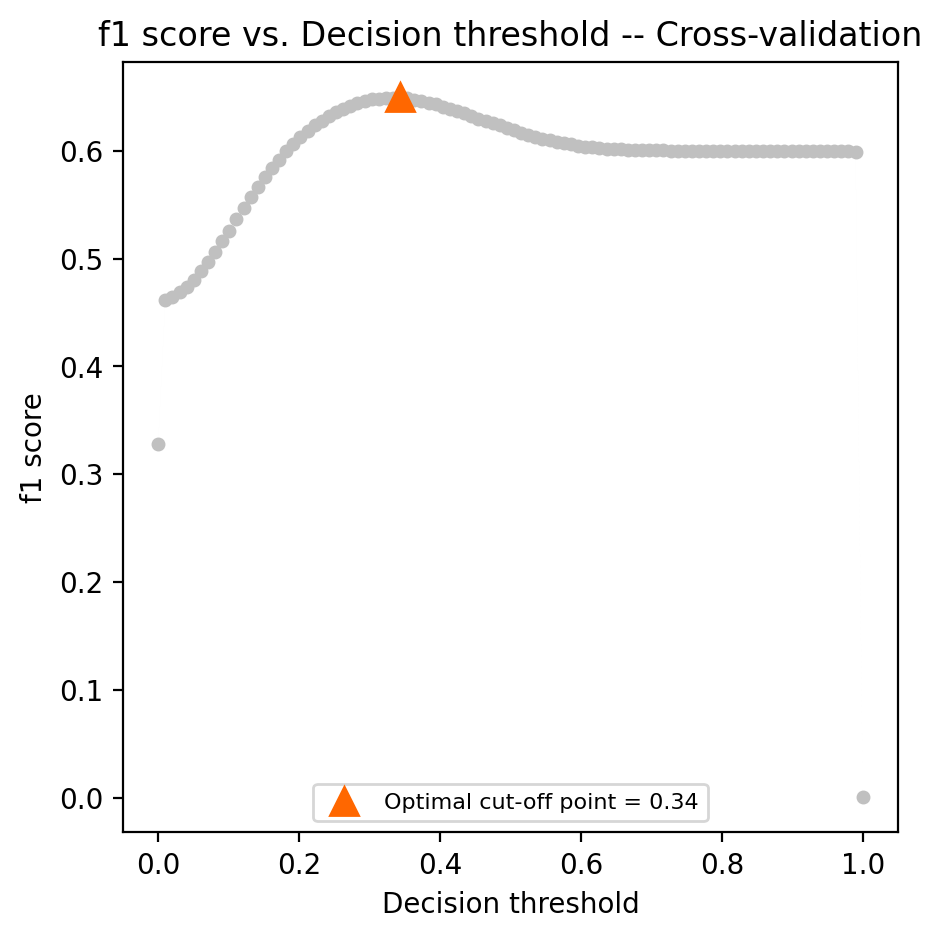

In [32]:
find_the_best_decision_threshold(XGB_best_model,x_train,y_train,x_test,y_test,scoring='f1')

#### Hyperparameter Tuning using Optuna

In [36]:
import optuna
from sklearn.model_selection import cross_val_score

In [41]:
# Creating objective function

def objective(trail):
    learning_rate = trail.suggest_float('learning_rate',1e-3, 1e-1)
    max_depth = trail.suggest_int('max_depth',2,8)
    min_samples_leaf = trail.suggest_int('min_samples_leaf',8,32)
    n_estimators = trail.suggest_int('n_estimators',100,300)
    
    xgb_model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth= max_depth,
        min_samples_leaf = min_samples_leaf,
        n_estimators = n_estimators,
        random_state = 42
    )
    
    pipe4_XGB = Pipeline(steps=[
        ('feature_engineering_pipeline',selected_FE_with_FS),
        ('xgb2',xgb_model)
    ])
    
    score = cross_val_score(pipe4_XGB,x_train,y_train_transformed,scoring='f1',cv=2).mean()
    
    return score
    

In [42]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler())
study.optimize(objective,n_trials=70)

[I 2024-10-12 17:04:43,831] A new study created in memory with name: no-name-6f031e6b-30cd-412a-a70c-a7822ffdd6c9
[I 2024-10-12 17:05:06,048] Trial 0 finished with value: 0.5997264566822289 and parameters: {'learning_rate': 0.009422970806706399, 'max_depth': 5, 'min_samples_leaf': 18, 'n_estimators': 120}. Best is trial 0 with value: 0.5997264566822289.
[I 2024-10-12 17:05:23,463] Trial 1 finished with value: 0.6104785240014341 and parameters: {'learning_rate': 0.028517489622349908, 'max_depth': 6, 'min_samples_leaf': 30, 'n_estimators': 265}. Best is trial 1 with value: 0.6104785240014341.
[I 2024-10-12 17:05:39,749] Trial 2 finished with value: 0.5997264566822289 and parameters: {'learning_rate': 0.06106336224106302, 'max_depth': 2, 'min_samples_leaf': 19, 'n_estimators': 259}. Best is trial 1 with value: 0.6104785240014341.
[I 2024-10-12 17:05:55,380] Trial 3 finished with value: 0.6116014957068356 and parameters: {'learning_rate': 0.03705308582344109, 'max_depth': 5, 'min_samples_l

In [44]:
study.best_trial.params
study.best_trial.value

{'learning_rate': 0.09637576993137481,
 'max_depth': 8,
 'min_samples_leaf': 20,
 'n_estimators': 292}

0.6224109899507219

In [45]:
best_model = XGBClassifier(**study.best_trial.params,random_state=42)

In [46]:
pipe_best = Pipeline(steps=[
    ('feature_engineering_pipeline',selected_FE_with_FS),
    ('best_model',best_model)
])

In [47]:
pipe_best.fit(x_train,y_train_transformed)

Pipeline(steps=[('feature_engineering_pipeline',
                 Pipeline(steps=[('feature_engineering_pipeline',
                                  FeatureUnion(transformer_list=[('combined_numerical_pipeline',
                                                                  Pipeline(steps=[('all_numerical',
                                                                                   FeatureUnion(transformer_list=[('num_skewed_pipeline',
                                                                                                                   Pipeline(steps=[('select_skewed_features',
                                                                                                                                    FunctionTransformer(func=<function <lambda> at 0x00000291A677B6A0>...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.09637576993137481, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               min_samples_leaf=20, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=292, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [48]:
y_pred_best = pipe_best.predict(x_test)

In [49]:
print(classification_report(y_test_transformed,y_pred_best))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     95507
           1       0.93      0.47      0.62     23302

    accuracy                           0.89    118809
   macro avg       0.91      0.73      0.78    118809
weighted avg       0.89      0.89      0.87    118809



Classification report: Training set
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    222850
           1       0.73      0.66      0.70     54371

    accuracy                           0.89    277221
   macro avg       0.83      0.80      0.81    277221
weighted avg       0.88      0.89      0.88    277221

Classification report: Test set
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     95507
           1       0.68      0.62      0.65     23302

    accuracy                           0.87    118809
   macro avg       0.80      0.77      0.78    118809
weighted avg       0.86      0.87      0.87    118809

Best threshold = 0.32 with f1 score = 0.65


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                                      Pipeline(steps=[('feature_engineering_pipeline',
                                                                       FeatureUnion(transformer_list=[('combined_numerical_pipeline',
                                                                                                       Pipeline(steps=[('all_numerical',
                                                                                                                        FeatureUnion(transformer_list=[('num_skewed_pipeline',
                                                                                                                                                        Pipeline(steps=[('select_skewed_features',
                                                                                                                                                                         FunctionTransformer(f...
                                                                    interaction_constraints=None,
                                                                    learning_rate=0.09637576993137481,
                                                                    max_bin=None,
                                                                    max_cat_threshold=None,
                                                                    max_cat_to_onehot=None,
                                                                    max_delta_step=None,
                                                                    max_depth=8,
                                                                    max_leaves=None,
                                                                    min_child_weight=None,
                                                                    min_samples_leaf=20,
                                                                    missing=nan,
                                                                    monotone_constraints=None,
                                                                    multi_strategy=None,
                                                                    n_estimators=292,
                                                                    n_jobs=None,
                                                                    num_parallel_tree=None, ...))]),
                           n_jobs=-1, scoring='f1', store_cv_results=True)

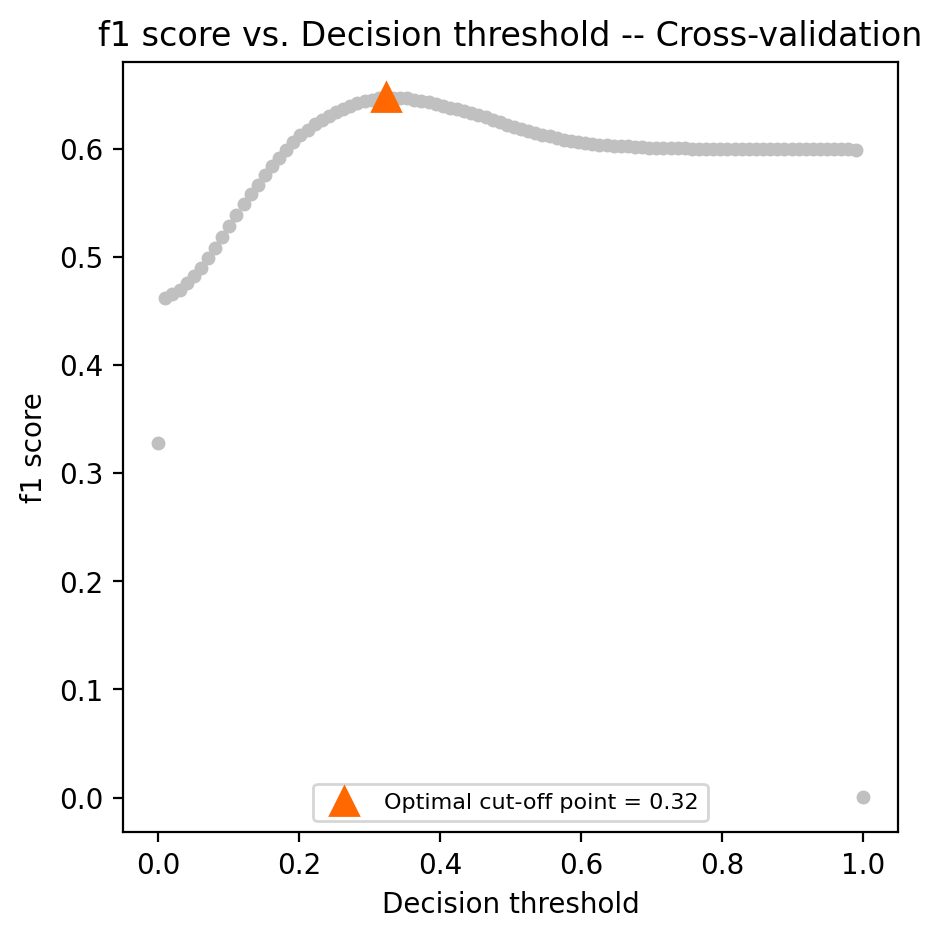

In [51]:
find_the_best_decision_threshold(pipe_best,x_train,y_train,x_test,y_test,scoring='f1')

#### Optuna Visualizations

In [52]:
from optuna.visualization import plot_optimization_history,plot_param_importances

In [57]:
import plotly

In [59]:
# plot_optimization_history(study).show()
# plot_param_importances(study).show()

#### Other scripts of this project

In [5]:
# import mlflow
# # Set the tracking URI to point to your MLflow server or local file store
# mlflow.set_tracking_uri("http://localhost:5000")

The below the MLflow command to serve a model as a web service. It will create a REST API to expose the model so it can handle HTTP requests, such as sending data to get predictions.

In [1]:
!poetry run mlflow models serve -m "models:/Optuna optimized XGB classifier@challenger" --port 5000 --no-conda

The below command runs the mlflow logging by using the MLProject file. Run the command from the same directory as in the MLProject file.

In [ ]:
!poetry run mlflow run . --experiment-name 'Model Optuna Optimization'

To serve the model in the terminal use the below command

In [ ]:
$env:MLFLOW_TRACKING_URI="http://127.0.0.1:5000" #The port here is the one where mflow model is registered (use the command if you are using windows)
export MLFLOW_TRACING_URI="http://127.0.0.1:5000" # Use this if you are using linux or macOS
!poetry run mlflow models serve -m "models:/Optuna optimized XGB classifier@challenger" --port 5002 --no-conda

# No conda is for asking to not create new conda environment and instead use the poetry created environment
# The model will be served on port 5002, you can invoke requests using postman


To run streamlit python files use the below command

In [ ]:
!poetry run streamlit run streamlit_app.py 

Live streamlit_app - https://creditriskmodel-aprewf5gesj6uqmo5y3ygx.streamlit.app/

To run flask app use the below script

In [ ]:
!poetry run python flask_app.py

To run fastapi_app.py use the below script

In [ ]:
!poetry run python fastapi_app.py # post to localhost:8000/predict, /doc in browser for documentation

Docker Scripts

1) docker buildx build --tag loantap_api2  .
* Explanation:

docker buildx build: This command is used to build a Docker image. buildx is an extended build command in Docker that supports advanced features, including building multi-platform images, faster builds, and more.
--tag loantap_api2: This assigns a tag (loantap_api2) to the Docker image. A tag is a name that allows you to reference the image easily later (e.g., when running the image).
. (dot): This tells Docker to look in the current directory (where the Dockerfile is located) for the source files and the Dockerfile itself to build the image.
In summary: This command builds a Docker image using the Dockerfile in the current directory, tagging the image as loantap_api2. You must run this command from the root of your project directory (where the Dockerfile and source code are located).

2. docker run -p 8000:8000 loantap_api2
* Explanation:

docker run: This command creates and starts a container from the specified Docker image.
-p 8000:8000: This option maps port 8000 on your host machine to port 8000 inside the Docker container. This is necessary because the FastAPI app inside the container is exposing port 8000 (as defined in your Dockerfile), and this command allows it to be accessible from the host system on the same port.
The first 8000 refers to the host port.
The second 8000 refers to the container port.
loantap_api2: This is the tag (or name) of the Docker image you created in the previous step. It tells Docker to run a container from this specific image.
In summary: This command runs the loantap_api2 image in a Docker container, forwarding port 8000 from the container to your host machine, allowing you to access the FastAPI application in the browser or through an API call at http://localhost:8000.

Script to push the Docker image to DockerHub

* docker login # For logging in to dockerHub
* docker tag api_name yourusername/api_name:v1  # For tagging the Docker image
* docker push yourusername/api_name:v1    # For pushing to dockerHub


Once this is done, anyone can pull the image from Docker Hub using:

docker pull yourusername/api_name:v1